# scrath notebook

In [34]:
%matplotlib inline
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp
import scipy.stats as stats
import pandas as pd
from pathlib import Path
from importlib import reload

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import TreeMazeAnalyses2,Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.plot_functions as pf
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Analyses.spatial_functions as sf

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

from joblib import delayed, Parallel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
ei = reload(ei)
info = ei.SummaryInfo()

In [12]:
subject_widget = widgets.Dropdown(options=info.subjects)
session_widget = widgets.Dropdown(options=info.sessions_by_subject[subject_widget.value])
task_widget = widgets.Dropdown(options=['T3', 'OF'])

def update_sessions(*args):
    all_sessions = info.sessions_by_subject[subject_widget.value]
    task_sessions = [session for session in all_sessions if task_widget.value in session]
    session_widget.options = task_sessions

def get_session(subject, task, session):
    return ei.SubjectSessionInfo(subject, session)

subject_widget.observe(update_sessions, names='value')
task_widget.observe(update_sessions, names='value')
o=widgets.interactive(get_session, subject=subject_widget, task=task_widget, session=session_widget)
display(o)

interactive(children=(Dropdown(description='subject', options=('Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi'), value='Li'…

In [13]:
session = session_widget.value
session_info = o.result
print(session_info)


Session Information for subject Li, session Li_OF_070618
Number of curated units: 18
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> scores. Executed = True
  -> encoding_models. Executed = True

To run all analyses use run_analyses().



In [14]:
fr = session_info.get_fr()
fr.shape

(18, 52836)

In [15]:
track_data = session_info.get_track_data()
track_data.keys()

dict_keys(['t', 'x', 'y', 'sp', 'ha', 'hd', 'pos_map_counts', 'pos_map_secs', 'pos_valid_mask', 'pos_map_counts_sm'])

In [19]:
x = track_data['x']
y = track_data['y']
unit = 5
fr_u = fr[5]

<AxesSubplot:>

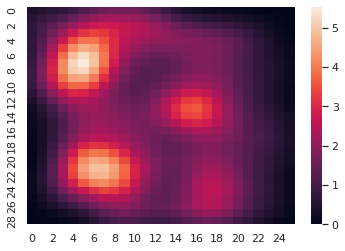

In [41]:
x_bin_edges = np.arange(-65,66,5)
y_bin_edges = np.arange(-10,140,5)
fr_u_rm = sf.firing_rate_2_rate_map(fr_u, x, y, x_bin_edges=x_bin_edges, y_bin_edges=y_bin_edges)
sns.heatmap(fr_u_rm)

In [53]:
import sklearn.linear_model as lm
from scipy.interpolate import LSQBivariateSpline as spline_2D

In [89]:
tx=np.arange(-65,66,30)
ty=np.arange(-10,140,30)
bbox = [-70, 70, -20, 150]
sp_model = spline_2D(x,y,fr_u,tx,ty, bbox=bbox,)

<AxesSubplot:>

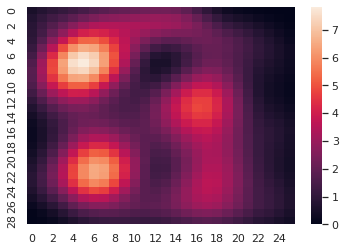

In [90]:
fr_u_hat_sp = sp_model.ev(x,y)
fr_u_hat_sp_rm = sf.firing_rate_2_rate_map(fr_u_hat_sp, x, y, x_bin_edges=x_bin_edges, y_bin_edges=y_bin_edges)
sns.heatmap(fr_u_hat_sp_rm)

## linear & simple

In [49]:
X = np.array((x,y, x*y)).T
model = lm.LinearRegression().fit(X,fr_u)

In [50]:
fr_u_hat = model.predict(X)

<AxesSubplot:>

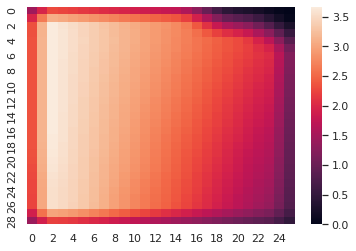

In [51]:
fr_u_hat_rm = sf.firing_rate_2_rate_map(fr_u_hat, x, y, x_bin_edges=x_bin_edges, y_bin_edges=y_bin_edges)
sns.heatmap(fr_u_hat_rm)

(array([4712., 7477., 5977., 4173., 4595., 5183., 6349., 5811., 5056.,
        3503.]),
 array([1.39013495, 1.65219865, 1.91426236, 2.17632607, 2.43838978,
        2.70045348, 2.96251719, 3.2245809 , 3.4866446 , 3.74870831,
        4.01077202]),
 <BarContainer object of 10 artists>)

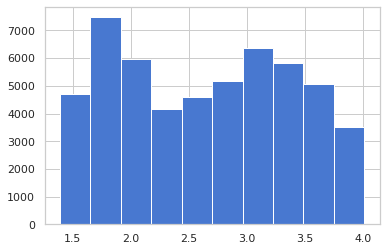

In [32]:
plt.hist(fr_u_hat)

(array([4.9217e+04, 2.3650e+03, 7.2500e+02, 2.7600e+02, 1.2400e+02,
        6.7000e+01, 3.7000e+01, 1.7000e+01, 7.0000e+00, 1.0000e+00]),
 array([  0.        ,  12.58155948,  25.16311896,  37.74467844,
         50.32623792,  62.9077974 ,  75.48935688,  88.07091636,
        100.65247584, 113.23403532, 125.8155948 ]),
 <BarContainer object of 10 artists>)

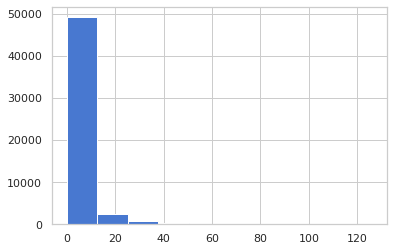

In [33]:
plt.hist(fr_u)

## linear and spline

In [101]:
%%time
X,_ = sf.get_position_encoding_features(x,y,x_bin_edges,y_bin_edges,feat_type='sparse')

CPU times: user 15.5 s, sys: 0 ns, total: 15.5 s
Wall time: 15.5 s


<AxesSubplot:>

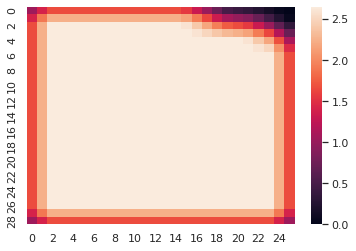

In [102]:
model = lm.LinearRegression().fit(X,fr_u_hat_sp)
fr_u_hat_rm = sf.firing_rate_2_rate_map(model.predict(X), x, y, x_bin_edges=x_bin_edges, y_bin_edges=y_bin_edges)
sns.heatmap(fr_u_hat_rm)

In [100]:
X[0]

(52836, 754)

## grids:

In [165]:
w = 100
h = 100
center = np.array((h//2,w//2))
scale = 30
theta =0
a=0.5
d_scale = 1.3
d_phase = np.array((h//8,w//8))
d_orientation = np.pi/18

params = dict(
            o=dict(width=w, height=h, center=center, scale=scale, theta=theta, a=a),
            s=dict(width=w, height=h, center=center, scale=scale*(d_scale), theta=theta, a=a),
            c=dict(width=w, height=h, center=center + d_phase, scale=scale, theta=theta, a=a),
            p=dict(width=w, height=h, center=center, scale=scale, theta=theta + d_orientation, a=a))

mg = {k:sf.generate_moire_grid(**v) for k,v in params.items()}
tittles = dict(o='original',
               s=f'scale x {d_scale}',
               c=f'phase + ({d_phase.astype(int)})',
               p=f'ori + {np.rad2deg(d_orientation):0.0f}deg')


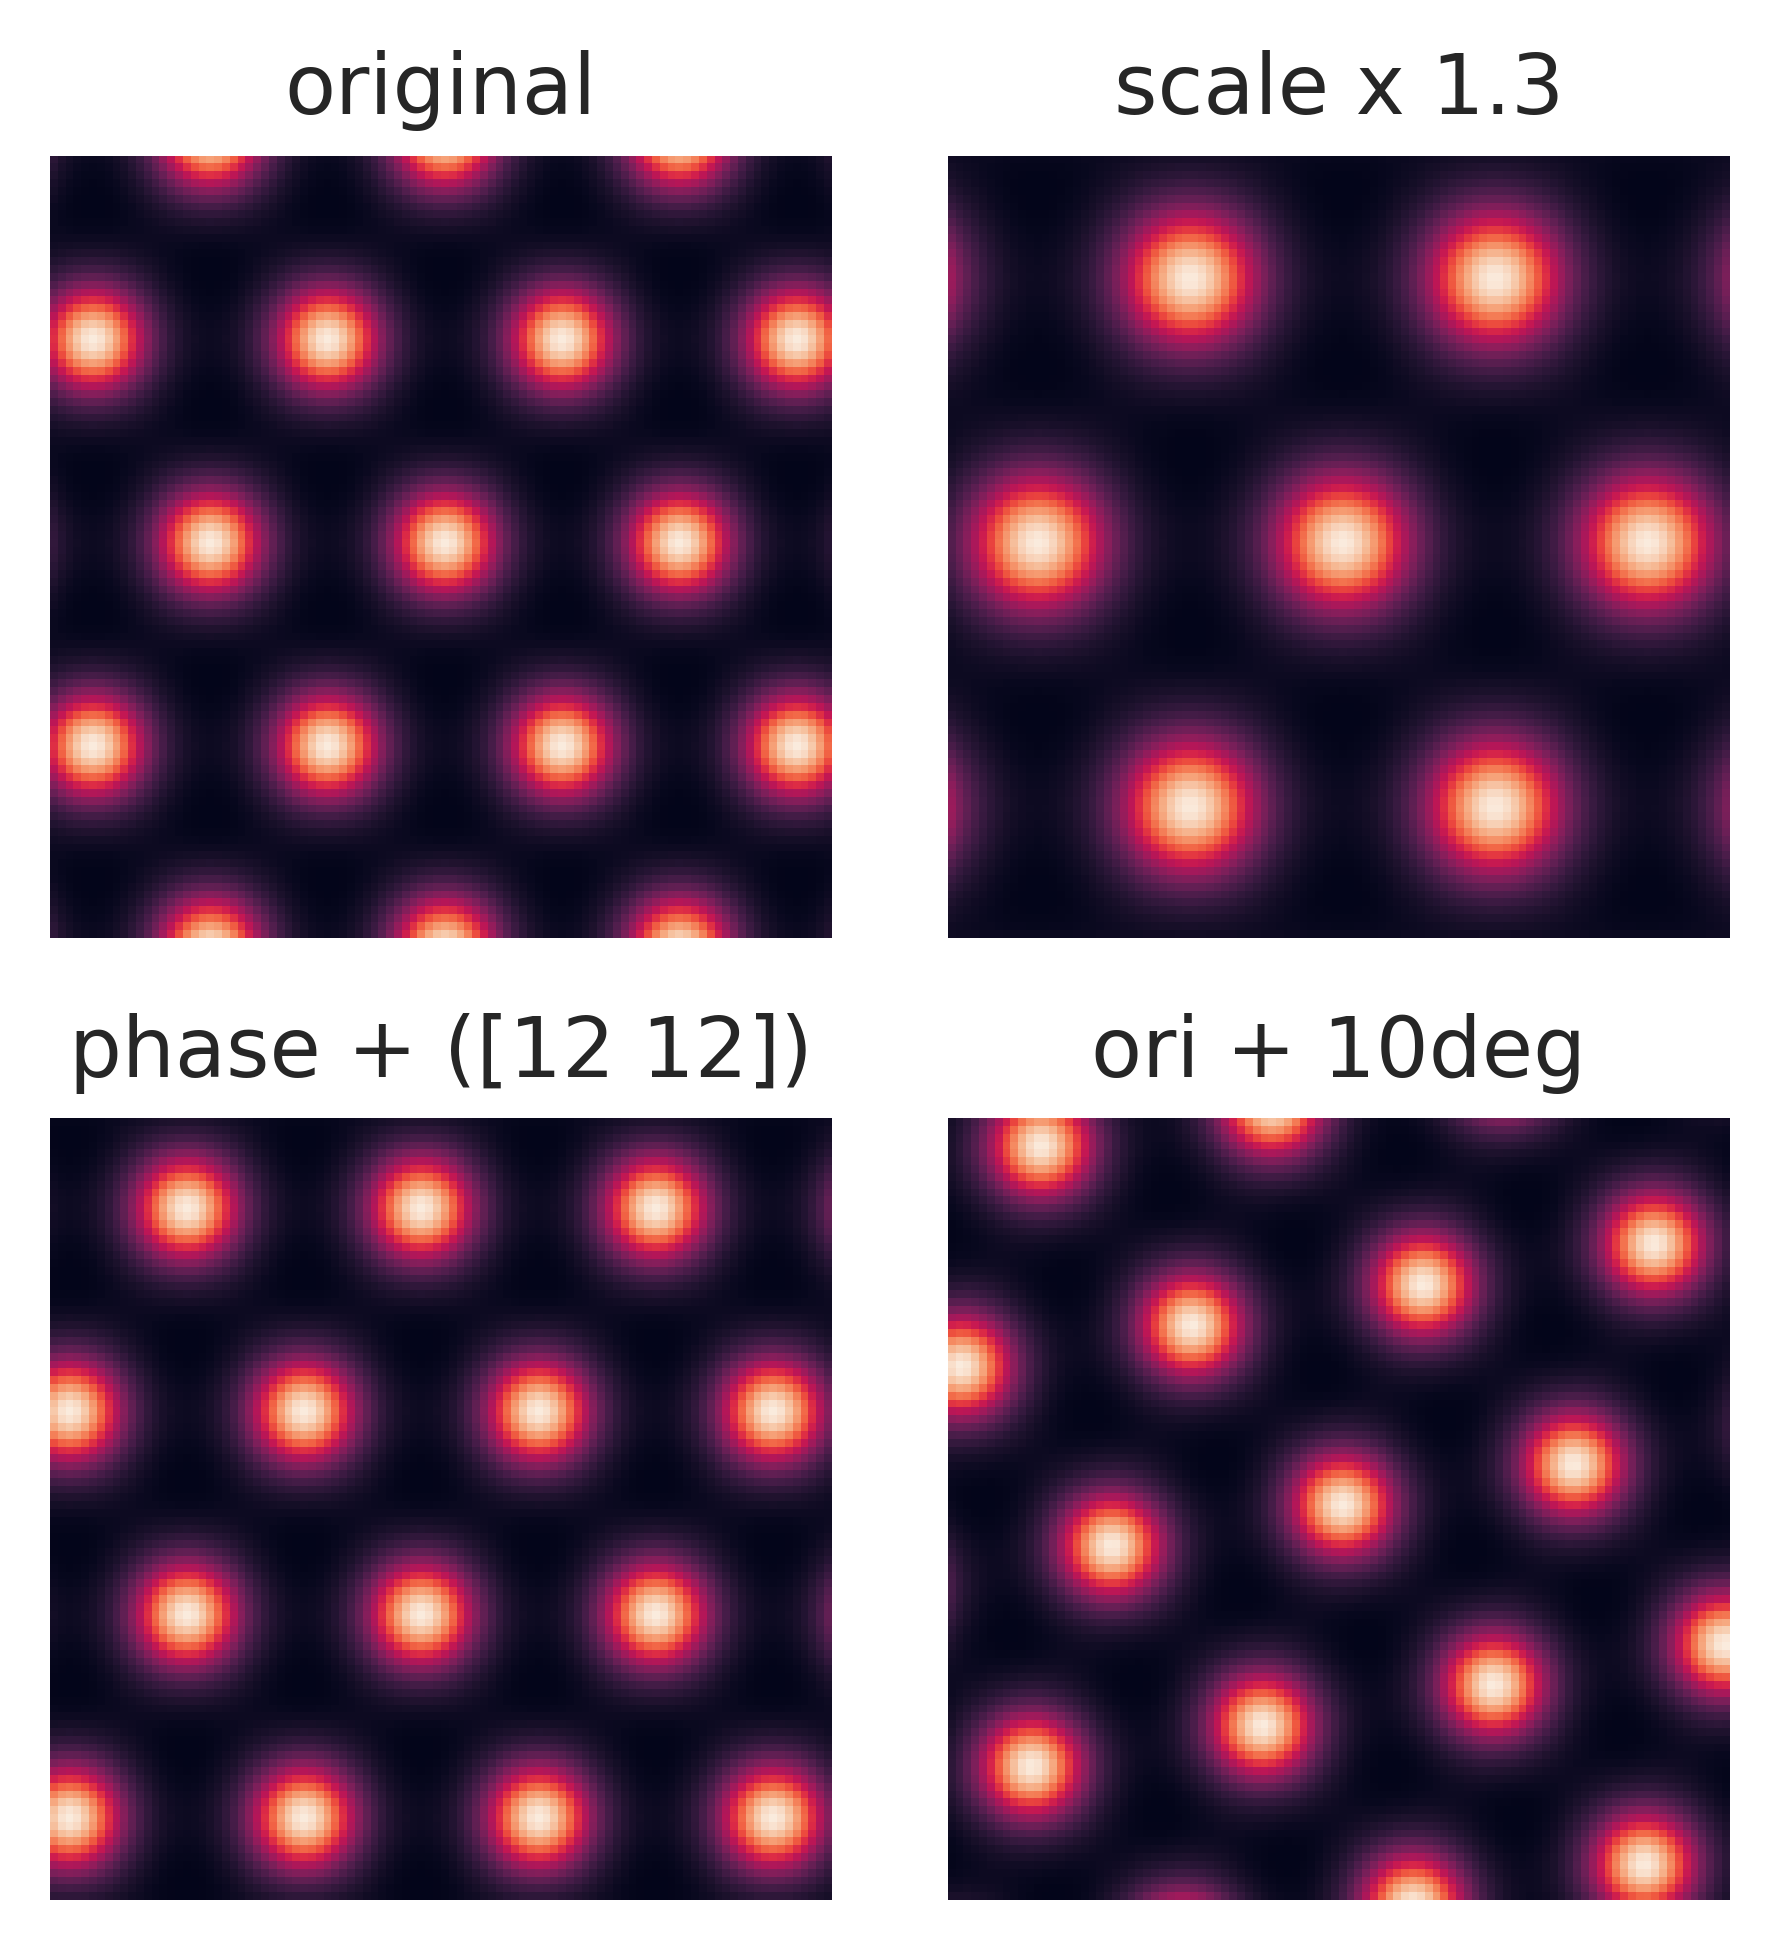

In [166]:
f,ax=plt.subplots(2,2, dpi=500,tight_layout=True)
ax=ax.flatten()

ks = params.keys()
for a, k in zip(ax,ks):
    sns.heatmap(mg[k], square=True, xticklabels=[], yticklabels=[], cbar=False, ax=a)
    a.invert_yaxis()
    a.set_title(tittles[k])
    

f.savefig(Path("/home/alexgonzalez/Desktop/grid_remapping"), pad_inches=0, bbox_inches='tight')

In [158]:
Path("/home/alexgonzalez/Desktop/grid_remapping")

PosixPath('/home/alexgonzalez/Documents/TreeMazeAnalyses2/Notebooks/~')

In [128]:
center+(-50,25)

(51, 51, -50, 25)